In [1]:
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


In [4]:
InputVariables = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Input Variables')
VS = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Vessel Schedule')
ChannelBerth = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Channel-Berth')
Tidal = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Tidal')
VesselSchedule = VS[:20]

,No.,Tide Type,Average range,Average Duration
0,1,High Tide #1,03:45:00 - 09:45:00,W = 6 hours
1,2,Low Tide #1\t,09:45 - 15:45,NaN
2,3,High Tide #2,15:45:00 - 21:45:00,NaN
3,4,Low Tide #2,21:45 - 03:45 (next day),NaN


In [68]:
TG0 = InputVariables.iloc[0, 2] #Thời gian cố định để tàu di chuyển qua kênh
W = InputVariables.iloc[1, 2] #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = InputVariables.iloc[2, 2] #Một số nguyên đủ lớn để ràng buộc
M = InputVariables.iloc[3, 2] #Tổng số xe tải có thể sử dụng
CE0 = float(InputVariables.iloc[4, 2]) / 60 #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
CF0 = float(InputVariables.iloc[5, 2]) / 60 #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải
n_ = InputVariables.iloc[9, 2] #Mức tiêu thụ nhiên liệu khi chạy không tải
E1 = float(InputVariables.iloc[10, 2]) #Hệ số phát thải carbon của xe tải
E2 = InputVariables.iloc[11, 2] #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = InputVariables.iloc[12, 2] #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = InputVariables.iloc[13, 2] #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
Channel = InputVariables.iloc[14, 2] #Kênh
V_name = VesselSchedule['Vessel Name'].tolist() #Vessel
TOi = VesselSchedule['TOi (Estimated Time of Arrival)'].tolist() # Thời gian dự kiến tàu đến
TFi = VesselSchedule['TFi (Estimated Time of departure)'].tolist() # Thời gian dự kiến tàu đi
TWi = VesselSchedule['TWi (Maximum waiting time, hour)'].tolist() # Thời gian chờ tối đa của tàu
VLi = VesselSchedule['VLi (Length, m)'].tolist() #VLi (Chiều dài tàu i) (mét)
VDi = VesselSchedule['VDi (Draft, m)'].tolist() #VDi (Mớn nước của tàu i) (mét)
VEi = VesselSchedule['VEi (Total container)'].tolist() #VEi (Số lượng container tàu chở)
VCmi = VesselSchedule['VCmi (Lower limit of quay cranes)'].tolist() #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = VesselSchedule['VCMi (Upper limit of quay cranes)'].tolist() #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
lst1 = [float(x) for x in VesselSchedule['Di1 (Distance vessel i at berth 1 - target \nyard, km)']]
lst2 = [float(x) for x in VesselSchedule['Di2 (Distance vessel i at berth 2 - target \nyard, km)']]
Dij = [[l1, l2] for l1, l2 in zip(lst1, lst2)]
D = np.array([[d[0]] for d in Dij], dtype=float)  # Đảm bảo D là mảng float (V, 1)
B = ChannelBerth['ID bến'].tolist() #Berth
BLj = ChannelBerth['BLj (Chiều dài của bến j ) (mét)'].tolist() #BLj (Chiều dài của bến j ) (mét)
BDj = ChannelBerth['BDj (Mớn nước tại bến j ) (mét)'].tolist() #BDj (Mớn nước tại bến j ) (mét)
Tt = [Tidal.iloc[0, 2], Tidal.iloc[2, 2]] #Khung thoi gian thuy trieu cao
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
w1 = InputVariables.iloc[15, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = InputVariables.iloc[16, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = InputVariables.iloc[17, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = InputVariables.iloc[18, 2] #Hằng số logarit
kTA = InputVariables.iloc[19, 2] # Hệ số tính toán thời gian chờ Erlang
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
T = [i for i in range(1,25)]
C = [i for i in range(1, 24)] #Crane
Y = [i for i in range(1, 46)] #Truck
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
VCi = VesselSchedule['VCmi (Lower limit of quay cranes)'].to_list() #Số lượng cần cẩu được phân công cố định cho tàu
VCit = VesselSchedule['VCMi (Upper limit of quay cranes)'].to_list() #Số lượng cần cẩu phục vụ
TWi = [float(val) for val in TWi]
x = []
for i in range(len(TWi)):
    x.append(np.random.normal(loc=float(TWi[i]) / 2, scale=float(TWi[i]) / 2))
u_TA = 1.0 / (sum(x) / len(x))
TH1 = [i / vh for i in lst1] #Thời gian xe tải rỗng ddi từ bến 1 
TH2 = [i / vh for i in lst2] #Thời gian xe tải rỗng ddi từ bến 2
TL1 = [i / vl for i in lst1] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 1
TL2 = [i / vl for i in lst2] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 2
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 
delTA = []  # Độ lệch thời gian dựa trên Erlang
TAi = []    # Thời gian đến thực tế sau khi cộng độ lệch
TE = [] #thời gian khởi hành của tàu đi ra khỏi kênh khi rời cảng
TDTS = []
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i
dtb = 500 #Dung tích bình xăng
def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e
Dl = float(dtb) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk = float(dtb) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
tn_ = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VEi)):
        TDTS.append(float(VEi[i])/(CE0 * VCit[i]))
calculate_con13()

def convert_time_to_float(time_val):
    if isinstance(time_val, str):
        dt = datetime.strptime(time_val, "%d/%m/%Y %H:%M:%S")
    elif isinstance(time_val, pd.Timestamp) or isinstance(time_val, datetime):
        dt = time_val
    else:
        raise ValueError(f"Unsupported type: {type(time_val)}")
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()
TO_float = [convert_time_to_float(t) for t in TOi]
def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA
def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst
calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)
TF_float = [convert_time_to_float(t) for t in TFi]
for i in range(len(TF_float)):
    TE.append(TF_float[i] - TWi[i])
TAi_float = [float(i) for i in TAi]
TB = [TAi_float[i] + 0.25 for i in range(len(TAi_float))]
TC = [TB[i] + TWi[i] for i in range(len(TB))] #Thời điểm tàu i đã vào cảng
TS = [TC[i] + float(10)/60 for i in range(len(TC))]     #Thời gian bắt đầu công việc cho tàu
TV = TS #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TS
TD = [TDTS[i] + TS[i] for i in range(len(TDTS))]
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi
def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
LS = 50 #Chiều dài an toàn (mét)

In [69]:
# np.random.seed(42)
# V = len(V_name)   # Số tàu
# B = 1   # Số bến
# C = 23  # Số cần cẩu
# Y = 45  # Số xe
# M = 99999  # Penalty
# T = 24
# CK = np.random.randint(0, 4, size=(C, T))
# # Dữ liệu đầu vào
# def convert_time_to_float(time_input):
#     if isinstance(time_input, datetime):
#         dt = time_input
#     elif isinstance(time_input, str):
#         dt = datetime.strptime(time_input, "%d/%m/%Y %H:%M:%S")
#     else:
#         raise TypeError("Input must be a string or datetime object.")
    
#     epoch = datetime(1970, 1, 1)
#     delta = dt - epoch
#     return delta.total_seconds()

# # Thời gian đến (TA) và thời gian xử lý dự kiến (PT)
# TA = np.array(TAi_float)  # Giờ
# PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Giờ

# DMN = 14
# # ==================== HÀM NGOÀI CLASS ====================
# def enforce_crane_constraints(q):
#     for i in range(V):
#         num_assigned = np.sum(q[i])
#         if num_assigned < VCmi[i]:
#             available = np.where(q[i] == 0)[0]
#             to_add = VCmi[i] - num_assigned
#             selected = np.random.choice(available, to_add, replace=False)
#             q[i, selected] = 1
#         elif num_assigned > VCMi[i]:
#             assigned = np.where(q[i] == 1)[0]
#             to_remove = num_assigned - VCMi[i]
#             selected = np.random.choice(assigned, to_remove, replace=False)
#             q[i, selected] = 0
#     return q

# def schedule_cranes(q2D, VE, CF0, T):
#     V, C = q2D.shape
#     q3D = np.zeros((V, C, T), dtype=int)

#     for i in range(V):  # mỗi tàu
#         assigned_cranes = np.where(q2D[i] == 1)[0]
#         num_cranes = len(assigned_cranes)
        
#         if num_cranes == 0:
#             continue

#         total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
#         duration = total_time // num_cranes
#         extra = total_time % num_cranes
#         start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

#         for j, c in enumerate(assigned_cranes):
#             dur = duration + (1 if j < extra else 0)
#             end_time = min(start_time + dur, T)
#             q3D[i][c][start_time:end_time] = 1
#             start_time = end_time  # tiếp nối cần cẩu kế tiếp

#     return q3D


# def crane_non_crossing_constraint(q):
#     for i in range(V):
#         for n in range(1, C - 1):
#             for t in range(T):
#                 left = q[i][n - 1][t]
#                 center = q[i][n][t]
#                 right = q[i][n + 1][t]
#                 if left == 1 and right == 1 and center == 0:
#                     return False
#     return True

# def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
#     C, T = CK.shape
#     V, B = D.shape

#     for t in range(T):
#         total_trucks = np.sum(CK[:, t])
#         if total_trucks > M:
#             return False

#     v_h = norm.rvs(mu_vh, sigma_vh)
#     v_l = norm.rvs(mu_vl, sigma_vl)

#     TH = D / v_h  # Thời gian không tải
#     TL = D / v_l  # Thời gian có tải

#     for n in range(C):
#         for t in range(T):
#             i, j = A[n, t]
#             ck = CK[n, t]
#             if ck == 0:
#                 continue
#             # Đảm bảo j không vượt quá chỉ số bến
#             j = 0
#             denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
#             CE_n = ck / denominator
#             if CE_n > CE0:
#                 return False
#     return True

# def check_vessel_berth_length_constraint(x, VLi, BLj):
#     V, B = x.shape
#     for i in range(V):
#         for j in range(B):
#             if x[i][j] == 1 and VLi[i] > BLj[j]:
#                 return False
#     return True
# def parse_tide_intervals(Tt):
#     intervals = []
#     for interval in Tt:
#         start_str, end_str = interval.split(" - ")
#         h1, m1, s1 = map(int, start_str.split(":"))
#         h2, m2, s2 = map(int, end_str.split(":"))
#         start = timedelta(hours=h1, minutes=m1, seconds=s1)
#         end = timedelta(hours=h2, minutes=m2, seconds=s2)
#         intervals.append((start, end))
#     return intervals

# def is_high_tide(dt, tide_intervals):
#     current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
#     for start, end in tide_intervals:
#         if start <= current_time <= end:
#             return True
#     return False


# def next_high_tide_time(dt, tide_intervals):
#     for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
#         new_date = dt.date() + timedelta(days=day_offset)
#         for start, _ in tide_intervals:
#             candidate = datetime.combine(new_date, (datetime.min + start).time())
#             if candidate > dt:
#                 return candidate
#     return dt + timedelta(hours=6)  # fallback


# def float_to_datetime(float_time):
#     epoch = datetime(1970, 1, 1)
#     return epoch + timedelta(seconds=float_time)

# def build_CK_A_from_sol(sol, V, C, T, B):
#     CK = np.zeros((C, T), dtype=int)
#     A = np.zeros((C, T, 2), dtype=int)
#     for i in range(V):
#         assigned_cranes = np.where(sol['q'][i] == 1)[0]
#         assigned_trucks = np.where(sol['y'][i] == 1)[0]
#         berth = 0  # chỉ còn 1 bến
#         for n in assigned_cranes:
#             for t in range(T//2):
#                 CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
#                 A[n, t] = [i, berth]
#     return CK, A

# def calc_carbon_emission(sol, V, C, T, D, E1, E2):
#     carbon_truck = 0
#     carbon_crane = 0
#     for i in range(V):
#         assigned_cranes = np.where(sol['q'][i] == 1)[0]
#         assigned_trucks = np.where(sol['y'][i] == 1)[0]
#         carbon_truck += len(assigned_trucks) * D[i, 0] * 2 * E1
#         carbon_crane += len(assigned_cranes) * (T//2) * E2
#     return carbon_truck, carbon_crane

# def check_berth_length_and_safety_constraint(schedule, VLi, LS, BLj):
#     # Kiểm tra tại mọi thời điểm, tổng chiều dài các tàu trong bến + LS không vượt quá BLj[0]
#     events = []
#     for s in schedule:
#         events.append((s['start'], 'in', s['length']))
#         events.append((s['end'], 'out', s['length']))
#     events.sort()
#     current_lengths = []
#     for time, typ, length in events:
#         if typ == 'in':
#             current_lengths.append(length)
#         else:
#             current_lengths.remove(length)
#         if current_lengths:
#             total_length = sum(current_lengths) + (len(current_lengths) + 1) * LS
#             if total_length > BLj[0]:
#                 return False
#     return True

# def can_add_ship_at_time(berth_history, new_start, new_end, new_length, LS, BLj):
#     # Lấy các tàu đang ở bến trong khoảng [new_start, new_end)
#     overlapping = [s for s in berth_history if not (s['end'] <= new_start or s['start'] >= new_end)]
#     total_length = sum(s['length'] for s in overlapping) + new_length
#     total_ls = (len(overlapping) + 1) * LS  # +1: khoảng cách giữa các tàu và 2 đầu bến
#     return (total_length + total_ls) <= BLj[0]
# # ==================== THUẬT TOÁN SOA ====================
# class SeagullOptimization:
#     def __init__(self, n_seagulls=50, max_iter=200):
#         self.n_seagulls = n_seagulls
#         self.max_iter = max_iter
        
#     def initialize(self):
#         self.population = []
#         for _ in range(self.n_seagulls):
#             sol = {
#                 'x': np.zeros((V, B), dtype=int),
#                 'q': np.zeros((V, C), dtype=int),
#                 'y': np.zeros((V, Y), dtype=int)
#             }
#             # Phân bổ tàu-bến
#             for i in range(V):
#                 sol['x'][i, np.random.randint(B)] = 1
            
#             # Phân bổ cần cẩu
#             for i in range(V):
#                 num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
#                 selected = np.random.choice(C, num_cranes, replace=False)
#                 sol['q'][i, selected] = 1
            
#             # Phân bổ xe
#             for i in range(V):
#                 num_trucks = np.random.randint(5, 11)
#                 selected = np.random.choice(Y, num_trucks, replace=False)
#                 sol['y'][i, selected] = 1
            
#             self.population.append(sol)
    
#     def fitness(self, sol):
#         makespan = 0
#         penalty = 0
#         completion_times = []
#         berth_history = []  # Lưu lịch sử tàu vào/ra bến
#         tide_intervals = parse_tide_intervals(Tt)

#         # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến (vẫn giữ để đảm bảo x đúng dạng)
#         for i in range(V):
#             if sum(sol['x'][i]) != 1:
#                 penalty += 1000 * abs(sum(sol['x'][i]) - 1)  # penalty mềm

#         # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
#         for n in range(C):
#             if sum(sol['q'][:, n]) > 1:
#                 penalty += 1000 * (sum(sol['q'][:, n]) - 1)

#         # Lên lịch cho từng tàu, lưu lại lịch sử vào/ra bến
#         for i in np.argsort(TA):
#             berth = 0  # Chỉ còn 1 bến
#             assigned_cranes = np.sum(sol['q'][i])
#             assigned_trucks = np.sum(sol['y'][i])

#             # Ràng buộc mớn nước
#             if VDi[i] > BDj[0]:
#                 penalty += 10000

#             # Ràng buộc chiều dài tàu không vượt quá chiều dài bến (từng tàu)
#             if VLi[i] > BLj[0]:
#                 penalty += 10000

#             if assigned_cranes == 0 or assigned_trucks == 0:
#                 penalty += 10000
#                 continue

#             arrival_dt = float_to_datetime(TA[i])
#             if VDi[i] > DMN:
#                 if not is_high_tide(arrival_dt, tide_intervals):
#                     arrival_dt = next_high_tide_time(arrival_dt, tide_intervals)
#                 TA_adjusted = convert_time_to_float(arrival_dt)
#             else:
#                 TA_adjusted = TA[i]

#             # Tìm thời điểm bắt đầu cho tàu này (không cần xét berth_schedule từng bến nữa)
#             # Để đơn giản, cho tàu bắt đầu ngay khi đến hoặc sau khi các tàu khác rời đi nếu cần
#             # (Lịch sử sẽ kiểm tra tổng chiều dài + LS)
#             # Tìm thời điểm sớm nhất có thể vào bến
#             earliest = float(TA_adjusted)
#             latest = earliest + TWi[i]  # hoặc một giá trị lớn hơn nếu muốn
#             handling_time = float((VEi[i] * CF0) / assigned_cranes)
            
#             # Tìm khoảng thời gian hợp lệ
#             step = 0.1  # bước kiểm tra, ví dụ 0.1 giờ
#             found = False
#             while earliest <= latest:
#                 end_time = earliest + handling_time
#                 if can_add_ship_at_time(berth_history, earliest, end_time, VLi[i], LS, BLj):
#                     berth_history.append({'ship': i, 'start': earliest, 'end': end_time, 'length': VLi[i]})
#                     found = True
#                     break
#                 earliest += step
            
#             if not found:
#                 # Nếu không xếp được, phạt nặng
#                 penalty += 100000

#         # Kiểm tra ràng buộc tổng chiều dài các tàu + LS tại mọi thời điểm
#         if not check_berth_length_and_safety_constraint(berth_history, VLi, LS, BLj):
#             penalty += 100000  # Penalty lớn nếu vi phạm

#         # Các ràng buộc khác giữ nguyên
#         q3D = schedule_cranes(sol['q'], VEi, CF0, T)
#         if not crane_non_crossing_constraint(q3D):
#             penalty += 10000

#         CK, A = build_CK_A_from_sol(sol, V, C, T, B)
#         mu_vh, sigma_vh = 25, 4
#         mu_vl, sigma_vl = 18, 3
#         if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
#             penalty += 10000
#         carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
#         w_carbon = 0.01
#         makespan = max(completion_times) if completion_times else M
#         # Lưu lịch sử vào solution để xuất báo cáo sau này
#         sol['berth_history'] = berth_history
#         return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty


    
#     def attack_prey(self, best_sol, current_sol):
#         new_sol = deepcopy(current_sol)
#         for key in ['x', 'q', 'y']:
#             mask = np.random.rand(*current_sol[key].shape) < 0.5
#             new_sol[key][mask] = best_sol[key][mask]
#         new_sol['q'] = enforce_crane_constraints(new_sol['q'])
#         return new_sol
    
#     def migrate(self, sol):
#         new_sol = deepcopy(sol)
#         for key in ['x', 'y']:
#             mutation = np.random.rand(*sol[key].shape) < 0.1
#             new_sol[key] = np.logical_xor(sol[key], mutation).astype(int)
        
#         # Đột biến có kiểm soát cho cần cẩu
#         for i in range(V):
#             if np.random.rand() < 0.1:
#                 num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
#                 new_sol['q'][i] = 0
#                 selected = np.random.choice(C, num_cranes, replace=False)
#                 new_sol['q'][i, selected] = 1
#         return new_sol
    
#     def optimize(self):
#         self.initialize()
#         best_sol = min(self.population, key=lambda x: self.fitness(x))
#         fitness_history = []
        
#         for iter in range(self.max_iter):
#             for i in range(self.n_seagulls):
#                 new_sol = self.attack_prey(best_sol, self.population[i])
#                 if np.random.rand() < 0.3:
#                     new_sol = self.migrate(new_sol)
#                 if self.fitness(new_sol) < self.fitness(self.population[i]):
#                     self.population[i] = new_sol
            
#             current_best = min(self.population, key=lambda x: self.fitness(x))
#             if self.fitness(current_best) < self.fitness(best_sol):
#                 best_sol = current_best
            
#             fitness_history.append(self.fitness(best_sol))
#             print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        
#         plt.plot(fitness_history)
#         plt.title("SOA Convergence")
#         plt.xlabel("Iteration")
#         plt.ylabel("Fitness (Makespan + Penalty)")
#         plt.grid(True)
#         plt.show()
#         return best_sol

# # ==================== CHẠY THUẬT TOÁN ====================
# soa = SeagullOptimization(n_seagulls=30, max_iter=100)
# best_solution = soa.optimize()

# # ==================== HIỂN THỊ KẾT QUẢ ====================
# # print("\nBest Solution:")
# # print("1. Phân bổ tàu-bến (x):")
# # print(best_solution['x'])

# # print("\n2. Phân bổ cần cẩu (q):")
# # print(best_solution['q'])

# # print("\n3. Phân bổ xe (y):")
# # print(best_solution['y'])

# # Tính toán thời gian chi tiết
# berth_schedule = {j: 0 for j in range(B)}
# # print("\nChi tiết thời gian:")
# for i in np.argsort(TA):
#     berth = 0  # Chỉ còn 1 bến
#     start = TA[i]
#     num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
#     handling_time = VEi[i] * CF0 / num_cranes if num_cranes > 0 else float('inf')
#     end = start + handling_time
#     # print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
#     berth_schedule[berth] = end

# makespan = (max(berth_schedule.values()) - min(TA)) / 3600  # Đơn vị: giờ
# # print(f"Makespan thực tế: {makespan:.2f} giờ")

# # ======= Xuất báo cáo lịch sử tàu vào/ra bến =======
# if 'berth_history' in best_solution:
#     # Gom nhóm các tàu vào bến cùng thời điểm
#     from collections import defaultdict

#     # Làm tròn thời gian start để gom nhóm (nếu cần)
#     group_by_start = defaultdict(list)
#     for record in best_solution['berth_history']:
#         rounded_start = round(record['start'], 0)
#         group_by_start[rounded_start].append(V_name[record['ship']])

#     # Sắp xếp theo thời gian vào bến
#     for idx, (start, ships) in enumerate(sorted(group_by_start.items()), 1):
#         print(f"Vào bến lần thứ {idx}: {ships}")

Iter 1, Best Fitness: 1790343180.7623498
Iter 2, Best Fitness: 1790327203.467521
Iter 3, Best Fitness: 1790303200.5152702
Iter 4, Best Fitness: 1790294201.4983928
Iter 5, Best Fitness: 1790273199.8576765
Iter 6, Best Fitness: 1790268202.4974942
Iter 7, Best Fitness: 1790253201.8950782
Iter 8, Best Fitness: 1790232204.178665
Iter 9, Best Fitness: 1790228202.9013996
Iter 10, Best Fitness: 1790214202.9575038
Iter 11, Best Fitness: 1790207203.332369
Iter 12, Best Fitness: 1790204203.2067437
Iter 13, Best Fitness: 1790204202.936937
Iter 14, Best Fitness: 1790202204.153569
Iter 15, Best Fitness: 1790201203.5386636
Iter 16, Best Fitness: 1790199203.236609
Iter 17, Best Fitness: 1790195203.023105
Iter 18, Best Fitness: 1790195202.674705
Iter 19, Best Fitness: 1790193202.830301
Iter 20, Best Fitness: 1790193202.712137
Iter 21, Best Fitness: 1790191202.4949691
Iter 22, Best Fitness: 1790190202.201173
Iter 23, Best Fitness: 1790189202.2421331
Iter 24, Best Fitness: 1790189202.2421331
Iter 25, Bes

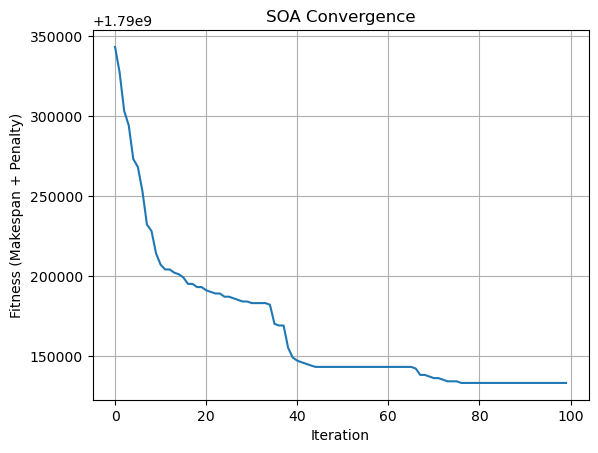

F1 = 57903.22976016327
F2 = 268324.5088204663
F3 = 17903893.29216
F = 1.0

Best Solution:
1. Phân bổ tàu-bến (x):
[[0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]]

2. Phân bổ cần cẩu (q):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

3. Phân bổ xe (y):
[[0 1 0 ... 1 0 1]
 [1 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 0 1 0]
 [0 1 0 ... 0 0 1]]

Chi tiết thời gian:
Tàu 0: Bến 1, Đến 2025-03-31 03:00:00.223026h, Bắt đầu 2025-03-31 03:00:00.223026h

In [70]:
np.random.seed(42)
V = len(V_name)   # Số tàu
B = 2   # Số bến
C = 23  # Số cần cẩu
Y = 45  # Số xe
M = 99999  # Penalty
TW0 = 24  # Thời gian chờ tối đa (h)
T = 24
CK = np.random.randint(0, 4, size=(C, T))
# Dữ liệu đầu vào

# Thời gian đến (TA) và thời gian xử lý dự kiến (PT)
TA = np.array(TAi_float)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Giờ

D = np.array(np.array(Dij))
DMN = 14
# ==================== HÀM NGOÀI CLASS ====================
def enforce_vessel_berth_constraint(x):
    for i in range(x.shape[0]):
        # Nếu không có bến nào được gán, gán ngẫu nhiên 1 bến
        if np.sum(x[i]) == 0:
            x[i, np.random.randint(x.shape[1])] = 1
        # Nếu có nhiều hơn 1 bến, chỉ giữ lại 1 bến (có thể chọn bến đầu tiên hoặc ngẫu nhiên)
        elif np.sum(x[i]) > 1:
            ones = np.where(x[i] == 1)[0]
            keep = np.random.choice(ones)
            x[i] = 0
            x[i, keep] = 1
    return x
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D


def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True
def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False


def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback


def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane
def calculate_F1(TF, TA):
    v = V
    total = sum(TFi - TAi for TFi, TAi in zip(TF, TA))
    F1 = (1 / v) * total
    return F1

def calculate_F2(E1, Dl, Dk, n_, tn_):
    pl = calculate_pvl(vh, l1)
    pk = calculate_pvl(vl, l2)
    F2 = E1 * (pl * Dl + pk * Dk + n_ * tn_)
    return F2
    
def calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2):
    part1 = 0
    part2 = 0
    part3 = 0
    for i in range(len(TD)):
        part1 += (TD[i] - TS[i]) * VCi[i]
        part2 += (TD[i] - TV[i]) * delVCit[i]
        part3 += delVCit[i]
    F3 = E2 * (lambda1 * (part1 + part2) + lambda2 * part3)
    return F3

def calculate_k123(a, b, c):
    return float(1)/a, float(1)/b, float(1)/c

# ==================== THUẬT TOÁN SOA ====================
class SeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        
    def initialize(self):
        self.population = []
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.zeros((V, B), dtype=int),
                'q': np.zeros((V, C), dtype=int),
                'y': np.zeros((V, Y), dtype=int)
            }
            # Phân bổ tàu-bến
            for i in range(V):
                sol['x'][i, np.random.randint(B)] = 1
            
            # Phân bổ cần cẩu
            for i in range(V):
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                selected = np.random.choice(C, num_cranes, replace=False)
                sol['q'][i, selected] = 1
            
            # Phân bổ xe
            for i in range(V):
                num_trucks = np.random.randint(5, 11)
                selected = np.random.choice(Y, num_trucks, replace=False)
                sol['y'][i, selected] = 1
            
            self.population.append(sol)
    
    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)
    
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += 1000 * abs(sum(sol['x'][i]) - 1)  # penalty mềm
    
        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += 1000 * (sum(sol['q'][:, n]) - 1)
    
        for i in np.argsort(TA):
            berth = np.argmax(sol['x'][i])
            assigned_cranes = np.sum(sol['q'][i])
            assigned_trucks = np.sum(sol['y'][i])
    
            if VDi[i] > BDj[berth]:
                penalty += 10000
    
            if VLi[i] > BLj[berth]:
                penalty += 10000
    
            if assigned_cranes == 0 or assigned_trucks == 0:
                penalty += 10000
                continue
            
            arrival_dt = float_to_datetime(TA[i])
            if VDi[i] > DMN:
                if not is_high_tide(arrival_dt, tide_intervals):
                    arrival_dt = next_high_tide_time(arrival_dt, tide_intervals)
                TA_adjusted = convert_time_to_float(arrival_dt)
            else:
                TA_adjusted = TA[i]
    
            start_time = max(float(TA_adjusted), float(berth_schedule[berth]))
            waiting_time = start_time - TA[i]
            if waiting_time > TWi[i]:
                penalty += 1000 * (waiting_time - TWi[i])  # penalty mềm
    
            processing_time = float((VEi[i] * CF0) / assigned_cranes)
            transport_delay = D[i, berth] / (assigned_trucks + 1e-5)
            completion = float(start_time + processing_time + transport_delay)
    
            completion_times.append(completion)
            berth_schedule[berth] = completion
    
        q3D = schedule_cranes(sol['q'], VEi, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += 10000
    
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += 10000
    
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += 10000
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        makespan = max(completion_times) if completion_times else M
        return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty


    
    def attack_prey(self, best_sol, current_sol):
        new_sol = deepcopy(current_sol)
        for key in ['x', 'q', 'y']:
            mask = np.random.rand(*current_sol[key].shape) < 0.5
            new_sol[key][mask] = best_sol[key][mask]
        new_sol['q'] = enforce_crane_constraints(new_sol['q'])
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        return new_sol
    
    def migrate(self, sol):
        new_sol = deepcopy(sol)
        for key in ['x', 'y']:
            mutation = np.random.rand(*sol[key].shape) < 0.1
            new_sol[key] = np.logical_xor(sol[key], mutation).astype(int)
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        # Đột biến có kiểm soát cho cần cẩu
        for i in range(V):
            if np.random.rand() < 0.1:
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                new_sol['q'][i] = 0
                selected = np.random.choice(C, num_cranes, replace=False)
                new_sol['q'][i, selected] = 1
        return new_sol
    
    def optimize(self):
        self.initialize()
        best_sol = min(self.population, key=lambda x: self.fitness(x))
        fitness_history = []
        
        for iter in range(self.max_iter):
            for i in range(self.n_seagulls):
                new_sol = self.attack_prey(best_sol, self.population[i])
                if np.random.rand() < 0.3:
                    new_sol = self.migrate(new_sol)
                if self.fitness(new_sol) < self.fitness(self.population[i]):
                    self.population[i] = new_sol
            
            current_best = min(self.population, key=lambda x: self.fitness(x))
            if self.fitness(current_best) < self.fitness(best_sol):
                best_sol = current_best
            
            fitness_history.append(self.fitness(best_sol))
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        
        plt.plot(fitness_history)
        plt.title("SOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# ==================== CHẠY THUẬT TOÁN ====================
soa = SeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = soa.optimize()

# ==================== HIỂN THỊ KẾT QUẢ ====================

F1 = calculate_F1(TF_float, TAi_float)
F2 = calculate_F2(E1, Dl, Dk, n_, tn_)
F3 = calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2)
k1, k2, k3 = calculate_k123(F1, F2, F3)

F = w1 * k1 * F1 + w2 * k2 * F2 + w3 * k3 * F3
print("F1 =", F1)
print("F2 =", F2)
print("F3 =", F3)
print("F =", F)
print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

# Tính toán thời gian chi tiết
berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TAi_float[i], berth_schedule[berth])
    wait = start - TA[i]
    end = start + PT[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VEi[i], num_cranes)
    end = TA[i] + handling_time
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

makespan = (max(berth_schedule.values()) - min(TA)) / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan:.2f} giờ")

Iter 1, Best Fitness: 1790352211.2616668
Iter 2, Best Fitness: 1790333215.4664953
Iter 3, Best Fitness: 1790332215.3734553
Iter 4, Best Fitness: 1790332215.3316472
Iter 5, Best Fitness: 1790332215.3096712
Iter 6, Best Fitness: 1790332215.3096712
Iter 7, Best Fitness: 1790294198.946466
Iter 8, Best Fitness: 1790293198.890946
Iter 9, Best Fitness: 1790283198.93865
Iter 10, Best Fitness: 1790283198.915602
Iter 11, Best Fitness: 1790283198.7903452
Iter 12, Best Fitness: 1790282198.711241
Iter 13, Best Fitness: 1790282198.691778
Iter 14, Best Fitness: 1790282198.691778
Iter 15, Best Fitness: 1790280199.4276178
Iter 16, Best Fitness: 1790270199.5176659
Iter 17, Best Fitness: 1790258198.988546
Iter 18, Best Fitness: 1790256198.8442738
Iter 19, Best Fitness: 1790254198.674274
Iter 20, Best Fitness: 1790254198.674274
Iter 21, Best Fitness: 1790254198.6330018
Iter 22, Best Fitness: 1790254198.612098
Iter 23, Best Fitness: 1790254198.598698
Iter 24, Best Fitness: 1790254198.582618
Iter 25, Best F

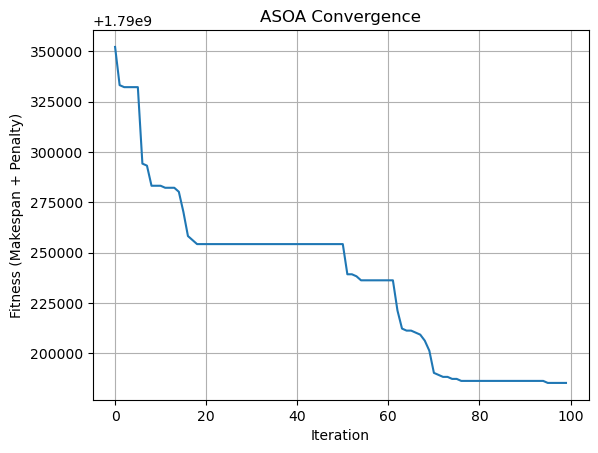


Best Solution:
1. Phân bổ tàu-bến (x):
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]

2. Phân bổ cần cẩu (q):
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]]

3. Phân bổ xe (y):
[[1 1 0 ... 0 1 1]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 1 1 0]
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 1 0]]

Chi tiết thời gian:
Tàu 0: Bến 0, Đến 2025-03-31 03:00:00.223026h, Bắt đầu 2025-03-31 03:00:00.223026h, Chờ 0.0h, Thời điểm kết thúc dự kiến: 2025-03-31 03:00:32.556360h
Tàu 1:

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import norm

# ==================== KHỞI TẠO TEST CASE ====================
np.random.seed(42)
V = len(V_name)   # Số tàu
B = 2   # Số bến
C = 23  # Số cần cẩu
Y = 45  # Số xe
M = 99999  # Penalty
TW0 = 24  # Thời gian chờ tối đa (h)
T = 24
CK = np.random.randint(0, 4, size=(C, T))
# Dữ liệu đầu vào
# Thời gian đến (TA) và thời gian xử lý dự kiến (PT)
TA = np.array(TAi_float)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Giờ

D = np.array(np.array(Dij))
DMN = 14
# ==================== HÀM NGOÀI CLASS ====================
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D


def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True
def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False


def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback




def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

# ==================== THUẬT TOÁN SOA ====================
class SeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        
    def initialize(self):
        self.population = []
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.zeros((V, B), dtype=int),
                'q': np.zeros((V, C), dtype=int),
                'y': np.zeros((V, Y), dtype=int)
            }
            # Phân bổ tàu-bến
            for i in range(V):
                sol['x'][i, np.random.randint(B)] = 1
            
            # Phân bổ cần cẩu
            for i in range(V):
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                selected = np.random.choice(C, num_cranes, replace=False)
                sol['q'][i, selected] = 1
            
            # Phân bổ xe
            for i in range(V):
                num_trucks = np.random.randint(5, 11)
                selected = np.random.choice(Y, num_trucks, replace=False)
                sol['y'][i, selected] = 1
            
            self.population.append(sol)
    def calc_A(self, t):
        fc = 2
        return fc * (np.cos(np.pi * (t / self.max_iter)) + 1) / 2
    
    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)
    
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += 1000 * abs(sum(sol['x'][i]) - 1)  # penalty mềm
    
        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += 1000 * (sum(sol['q'][:, n]) - 1)
    
        for i in np.argsort(TA):
            berth = np.argmax(sol['x'][i])
            assigned_cranes = np.sum(sol['q'][i])
            assigned_trucks = np.sum(sol['y'][i])
    
            if VDi[i] > BDj[berth]:
                penalty += 10000
    
            if VLi[i] > BLj[berth]:
                penalty += 10000
    
            if assigned_cranes == 0 or assigned_trucks == 0:
                penalty += 10000
                continue
            
            arrival_dt = float_to_datetime(TA[i])
            if VDi[i] > DMN:
                if not is_high_tide(arrival_dt, tide_intervals):
                    arrival_dt = next_high_tide_time(arrival_dt, tide_intervals)
                TA_adjusted = convert_time_to_float(arrival_dt)
            else:
                TA_adjusted = TA[i]
    
            start_time = max(float(TA_adjusted), float(berth_schedule[berth]))
            waiting_time = start_time - TA[i]
            if waiting_time > TWi[i]:
                penalty += 1000 * (waiting_time - TWi[i])  # penalty mềm
    
            processing_time = float((VEi[i] * CF0) / assigned_cranes)
            transport_delay = D[i, berth] / (assigned_trucks + 1e-5)
            completion = float(start_time + processing_time + transport_delay)
    
            completion_times.append(completion)
            berth_schedule[berth] = completion
    
        q3D = schedule_cranes(sol['q'], VEi, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += 10000
    
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += 10000
    
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += 10000
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        makespan = max(completion_times) if completion_times else M
        return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty


    
    def attack_prey(self, best_sol, current_sol, A):
        new_sol = deepcopy(current_sol)
        for key in ['x', 'q', 'y']:
            mask_prob = 0.7 * (A / 2) + 0.3  # mask_prob từ 1.0 -> 0.3
            mask = np.random.rand(*current_sol[key].shape) < mask_prob
            new_sol[key][mask] = best_sol[key][mask]
        new_sol['q'] = enforce_crane_constraints(new_sol['q'])
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        return new_sol
    
    def migrate(self, sol, A):
        new_sol = deepcopy(sol)
        mutation_rate = 0.2 * (A / 2) + 0.05  # mutation_rate từ 0.2 -> 0.05
        for key in ['x', 'y']:
            mutation = np.random.rand(*sol[key].shape) < mutation_rate
            new_sol[key] = np.logical_xor(sol[key], mutation).astype(int)
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        # Đột biến nhẹ cho q
        for i in range(V):
            if np.random.rand() < mutation_rate:
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                new_sol['q'][i] = 0
                selected = np.random.choice(C, num_cranes, replace=False)
                new_sol['q'][i, selected] = 1
        return new_sol
    
    def optimize(self):
        self.initialize()
        best_sol = min(self.population, key=lambda x: self.fitness(x))
        fitness_history = []
        for iter in range(self.max_iter):
            A = self.calc_A(iter)
            migrate_prob = 0.3 * (A / 2) + 0.1  # migrate_prob từ 0.4 -> 0.1
            for i in range(self.n_seagulls):
                new_sol = self.attack_prey(best_sol, self.population[i], A)
                if np.random.rand() < migrate_prob:
                    new_sol = self.migrate(new_sol, A)
                if self.fitness(new_sol) < self.fitness(self.population[i]):
                    self.population[i] = new_sol
            current_best = min(self.population, key=lambda x: self.fitness(x))
            if self.fitness(current_best) < self.fitness(best_sol):
                best_sol = current_best
            fitness_history.append(self.fitness(best_sol))
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        plt.plot(fitness_history)
        plt.title("ASOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# ==================== CHẠY THUẬT TOÁN ====================
soa = SeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = soa.optimize()

# ==================== HIỂN THỊ KẾT QUẢ ====================
print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

# Tính toán thời gian chi tiết
berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TAi_float[i], berth_schedule[berth])
    wait = start - TA[i]
    end = start + PT[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VEi[i], num_cranes)
    end = TA[i] + handling_time
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

makespan = (max(berth_schedule.values()) - min(TA)) / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan:.2f} giờ")

Iter 1, Best Fitness: 5803215065.973168
Iter 2, Best Fitness: 5803115066.7962885
Iter 3, Best Fitness: 5803115066.7962885
Iter 4, Best Fitness: 5803015068.022048
Iter 5, Best Fitness: 5803015067.892768
Iter 6, Best Fitness: 5803015067.892768
Iter 7, Best Fitness: 5803015067.892768
Iter 8, Best Fitness: 5802915068.957088
Iter 9, Best Fitness: 5802915068.957088
Iter 10, Best Fitness: 5802915068.957088
Iter 11, Best Fitness: 5802915068.957088
Iter 12, Best Fitness: 5802915068.957088
Iter 13, Best Fitness: 5802915068.951728
Iter 14, Best Fitness: 5802915068.951728
Iter 15, Best Fitness: 5802915068.951728
Iter 16, Best Fitness: 5802915068.951728
Iter 17, Best Fitness: 5802915068.936289
Iter 18, Best Fitness: 5802915068.936289
Iter 19, Best Fitness: 5802915068.936289
Iter 20, Best Fitness: 5802915068.936289
Iter 21, Best Fitness: 5802915068.936289
Iter 22, Best Fitness: 5802915068.898768
Iter 23, Best Fitness: 5802915068.849888
Iter 24, Best Fitness: 5802915068.849888
Iter 25, Best Fitness: 

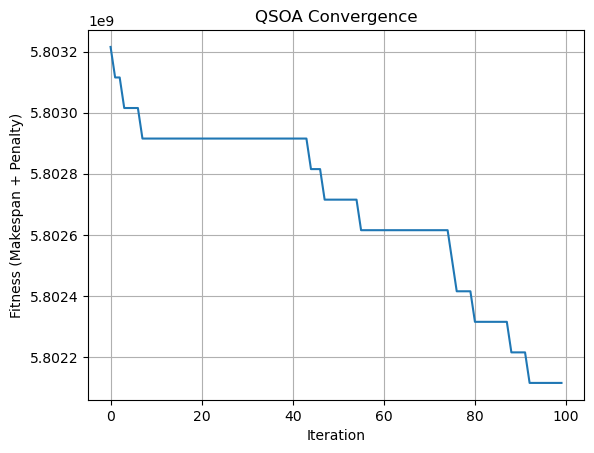


Best Solution:
1. Phân bổ tàu-bến (x):
[[0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]

2. Phân bổ cần cẩu (q):
[[0 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

3. Phân bổ xe (y):
[[0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 1 ... 0 1 0]
 [0 1 0 ... 0 0 0]]

Chi tiết thời gian:
Tàu 0: Bến 1, Đến 2025-03-31 03:00:00.223026h, Bắt đầu 2025-03-31 03:00:00.223026h, Chờ 0.0h, Thời điểm kết thúc dự kiến: 2025-03-31 03:00:21.778582h
Tàu 1:

In [73]:
np.random.seed(42)
V = len(V_name)  # Số tàu
B = 2   # Số bến
C = 23  # Số cần cẩu
Y = 45  # Số xe
M = 99999  # Penalty
TW0 = 24  # Thời gian chờ tối đa (h)
T = 24
CK = np.random.randint(0, 4, size=(C, T))

# --- Copy các biến, hàm ràng buộc, fitness từ test.ipynb vào đây ---
# (bao gồm: các biến dữ liệu, enforce_crane_constraints, schedule_cranes, check_truck_constraints, build_CK_A_from_sol, calc_carbon_emission, fitness...)
# Dữ liệu đầu vào

# Thời gian đến (TA) và thời gian xử lý dự kiến (PT)
TA = np.array(TAi_float)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Giờ

D = np.array(np.array(Dij))
DMN = 14
# ==================== HÀM NGOÀI CLASS ====================
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D

def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True

def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False

def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback


def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

def enforce_crane_constraints_optimized(q, VCmi, VCMi, carbon_emission_matrix=None):
    for i in range(q.shape[0]):  # với mỗi tàu
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            # Ưu tiên chọn cần cẩu có phát thải thấp nhất
            if carbon_emission_matrix is not None:
                sorted_idx = available[np.argsort(carbon_emission_matrix[i, available])]
            else:
                sorted_idx = available
            to_add = VCmi[i] - num_assigned
            selected = sorted_idx[:to_add]
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            # Loại bỏ cần cẩu có phát thải cao nhất
            if carbon_emission_matrix is not None:
                sorted_idx = assigned[np.argsort(-carbon_emission_matrix[i, assigned])]
            else:
                sorted_idx = assigned
            to_remove = num_assigned - VCMi[i]
            selected = sorted_idx[:to_remove]
            q[i, selected] = 0
    return q

# === HÀM QUANTUM GATE ===
def quantum_revolving_gate(phi, delta_phi):
    return phi + delta_phi

def quantum_not_gate(phi):
    return np.pi/2 - phi

# === QSOA CLASS ===
class QuantumSeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200, pm=0.1):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        self.pm = pm  # probability of NOT gate

    def initialize(self):
        self.population_phi = []
        for _ in range(self.n_seagulls):
            phi = {
                'x': np.random.uniform(0, 2*np.pi, (V, B)),
                'q': np.random.uniform(0, 2*np.pi, (V, C)),
                'y': np.random.uniform(0, 2*np.pi, (V, Y))
            }
            self.population_phi.append(phi)
            
    @staticmethod
    def enforce_truck_constraints_optimized(y, num_trucks, min_truck_per_vessel=1, max_truck_per_vessel=10):
        V, M = y.shape
        # Step 1: Ensure each vessel has at least min_truck_per_vessel trucks, not exceeding max_truck_per_vessel
        for i in range(V):
            current = np.sum(y[i])
            if current < min_truck_per_vessel:
                available = np.where(np.sum(y, axis=0) == 0)[0]
                to_add = min_truck_per_vessel - current
                if len(available) >= to_add:
                    selected = np.random.choice(available, to_add, replace=False)
                    y[i, selected] = 1
                else:
                    selected = np.random.choice(M, to_add, replace=False)
                    y[i, selected] = 1
            if np.sum(y[i]) > max_truck_per_vessel:
                assigned = np.where(y[i] == 1)[0]
                to_remove = np.sum(y[i]) - max_truck_per_vessel
                selected = np.random.choice(assigned, to_remove, replace=False)
                y[i, selected] = 0

        # Step 2: Prioritize truck allocation for vessels with more cranes
        # if hasattr(self, 'last_q'):
        #     cranes_per_vessel = np.sum(self.last_q, axis=1)
        #     sort_idx = np.argsort(-cranes_per_vessel)  # tàu nhiều cần cẩu trước
        # else:
        sort_idx = np.arange(V)
        # Bước 3: Nếu tổng số xe vượt quá num_trucks, loại bớt xe từ tàu ít cần cẩu hơn
        while np.sum(y) > num_trucks:
            for i in reversed(sort_idx):
                assigned = np.where(y[i] == 1)[0]
                if len(assigned) > min_truck_per_vessel:
                    y[i, assigned[0]] = 0
                    break
            else:
                break
        # Bước 4: Nếu tổng số xe còn thiếu, phân bổ thêm cho tàu nhiều cần cẩu hơn
        while np.sum(y) < num_trucks:
            for i in sort_idx:
                assigned = np.where(y[i] == 0)[0]
                if np.sum(y[i]) < max_truck_per_vessel and len(assigned) > 0:
                    y[i, assigned[0]] = 1
                    break
            else:
                break
        return y
        
    
    def phi_to_solution(self, phi):
        x_bin = (np.cos(phi['x']) > 0).astype(int)
        for i in range(x_bin.shape[0]):
            if np.sum(x_bin[i]) != 1:
                idx = np.argmax(phi['x'][i])
                x_bin[i] = 0
                x_bin[i, idx] = 1
        q_bin = (np.cos(phi['q']) > 0).astype(int)
        q_bin = enforce_crane_constraints_optimized(q_bin, VCmi, VCMi)
        y_bin = (np.cos(phi['y']) > 0).astype(int)
        y_bin = self.enforce_truck_constraints_optimized(y_bin, M)
        return {'x': x_bin, 'q': q_bin, 'y': y_bin}

    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)

        tide_intervals = parse_tide_intervals(Tt)  # Giả định Tt là một danh sách ["3:00:00 - 6:00:00", ...]

        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += M

        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += M

        for i in np.argsort(TA):  # xử lý theo thứ tự tàu đến
            berth = np.argmax(sol['x'][i])
            assigned_cranes = np.sum(sol['q'][i])
            assigned_trucks = np.sum(sol['y'][i])

            if VDi[i] > BDj[berth]:
                penalty += M

    # Ràng buộc chiều dài
            if VLi[i] > BLj[berth]:
                penalty += M

            if assigned_cranes == 0 or assigned_trucks == 0:
                penalty += M
                continue

            # Kiểm tra điều kiện thủy triều
            arrival_dt = float_to_datetime(TA[i])
            if VDi[i] > DMN:
                # Tàu lớn: chỉ được cập cảng/xuất cảng trong khung giờ thủy triều cao
                if not is_high_tide(arrival_dt, tide_intervals):
                    arrival_dt = next_high_tide_time(arrival_dt, tide_intervals)
                TA_adjusted = convert_time_to_float(arrival_dt)
            else:
                # Tàu nhỏ: cập cảng bất kỳ lúc nào
                TA_adjusted = TA[i]


            start_time = max(float(TA_adjusted), float(berth_schedule[berth]))
            waiting_time = start_time - TA[i]
            if waiting_time > TWi[i]:
                penalty += M * (waiting_time - TWi[i])

            processing_time = float((VEi[i] * CF0) / assigned_cranes)
            transport_delay = D[i, berth] / (assigned_trucks + 1e-5)
            completion = float(start_time + processing_time + transport_delay)


            completion_times.append(completion)
            berth_schedule[berth] = completion
            
        # Ràng buộc: Cần cẩu không nhảy qua nhau
        q3D = schedule_cranes(sol['q'], VEi, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += M

        # Ràng buộc: Chiều dài tàu không vượt chiều dài bến
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += M

                # === BƯỚC 1: Xây dựng CK, A ===
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        # === BƯỚC 2: Kiểm tra ràng buộc xe tải ===
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += M * 10
        # === BƯỚC 3: Tính khí thải carbon ===
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        makespan = max(completion_times) if completion_times else M
        fitness_value = makespan + w_carbon * (carbon_truck + carbon_crane) + penalty
        if fitness_value < 0:
            fitness_value = 1e12  # hoặc giá trị lớn dương
        return fitness_value

    def optimize(self):
        self.initialize()
        fitness_history = []
        best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
        best_sol = self.phi_to_solution(best_phi)

        for iter in range(self.max_iter):
            new_population_phi = []
            best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
            new_population_phi.append(best_phi)
            for phi in self.population_phi:
                # --- Quantum Revolving Gate update ---
                delta_phi_x = np.random.uniform(-np.pi/16, np.pi/16, phi['x'].shape)
                delta_phi_q = np.random.uniform(-np.pi/16, np.pi/16, phi['q'].shape)
                delta_phi_y = np.random.uniform(-np.pi/16, np.pi/16, phi['y'].shape)
                phi_new = {
                    'x': quantum_revolving_gate(phi['x'], delta_phi_x),
                    'q': quantum_revolving_gate(phi['q'], delta_phi_q),
                    'y': quantum_revolving_gate(phi['y'], delta_phi_y)
                }
                # --- Quantum NOT Gate (với xác suất pm) ---
                if np.random.rand() < self.pm:
                    phi_new['x'] = quantum_not_gate(phi_new['x'])
                    phi_new['q'] = quantum_not_gate(phi_new['q'])
                    phi_new['y'] = quantum_not_gate(phi_new['y'])
                new_population_phi.append(phi_new)
            self.population_phi = new_population_phi
            best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
            best_sol = self.phi_to_solution(best_phi)
            fitness_history.append(self.fitness(best_sol))
            
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        plt.plot(fitness_history)
        plt.title("QSOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# --- Hướng dẫn sử dụng ---
qsoa = QuantumSeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = qsoa.optimize()
print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TA[i], berth_schedule[berth])
    wait = start - TA[i]
    end = start + PT[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VEi[i], num_cranes)
    end = TA[i] + handling_time
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

makespan = (max(berth_schedule.values()) - min(TA)) / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan:.2f} giờ")

Iter 1, Best Fitness: 1790317199.1337395
Iter 2, Best Fitness: 1790294346.442312
Iter 3, Best Fitness: 1790277236.3019576
Iter 4, Best Fitness: 1790274237.6190152
Iter 5, Best Fitness: 1790248236.8989031
Iter 6, Best Fitness: 1790242236.3609655
Iter 7, Best Fitness: 1790239202.1472926
Iter 8, Best Fitness: 1790229200.4884684
Iter 9, Best Fitness: 1790221200.4954422
Iter 10, Best Fitness: 1790214200.7167566
Iter 11, Best Fitness: 1790197347.8577712
Iter 12, Best Fitness: 1790196347.8901553
Iter 13, Best Fitness: 1790193347.3483953
Iter 14, Best Fitness: 1790188347.0584671
Iter 15, Best Fitness: 1790188347.0584671
Iter 16, Best Fitness: 1790185348.9610097
Iter 17, Best Fitness: 1790181347.9250433
Iter 18, Best Fitness: 1790179347.5122352
Iter 19, Best Fitness: 1790177347.1412354
Iter 20, Best Fitness: 1790176236.6061127
Iter 21, Best Fitness: 1790174347.0180912
Iter 22, Best Fitness: 1790174346.8771234
Iter 23, Best Fitness: 1790174236.4409368
Iter 24, Best Fitness: 1790173236.2760727
It

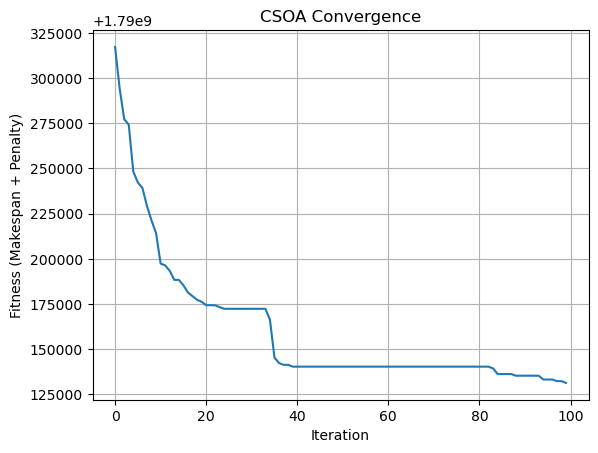


Best Solution:
1. Phân bổ tàu-bến (x):
[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]

2. Phân bổ cần cẩu (q):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]

3. Phân bổ xe (y):
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]

Chi tiết thời gian:
Tàu 0: Bến 1, Đến 2025-03-31 03:00:00.223026h, Bắt đầu 2025-03-31 03:00:00.223026h, Chờ 0.0h, Thời điểm kết thúc dự kiến: 2025-03-31 03:00:32.556360h
Tàu 1:

In [74]:
np.random.seed(42)
V = len(V_name)   # Số tàu
B = 2   # Số bến
C = 23  # Số cần cẩu
Y = 45  # Số xe
M = 99999  # Penalty
TW0 = 24  # Thời gian chờ tối đa (h)
T = 24
CK = np.random.randint(0, 4, size=(C, T))

# --- Copy các biến, hàm ràng buộc, fitness từ test.ipynb vào đây ---
# (bao gồm: các biến dữ liệu, enforce_crane_constraints, schedule_cranes, check_truck_constraints, build_CK_A_from_sol, calc_carbon_emission, fitness...)
# Dữ liệu đầu vào

# Thời gian đến (TA) và thời gian xử lý dự kiến (PT)
TA = np.array(TAi_float)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Giờ

D = np.array(np.array(Dij))
DMN = 14

# ==================== HÀM NGOÀI CLASS ====================
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D


def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True
def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False


def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback


def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)

def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

# --- Hàm sinh chuỗi hỗn loạn Cat map 2 chiều ---
def cat_map_2d(x0, y0, n):
    xs, ys = [x0], [y0]
    for _ in range(n-1):
        x_new = (xs[-1] + ys[-1]) % 1
        y_new = (xs[-1] + 2*ys[-1]) % 1
        xs.append(x_new)
        ys.append(y_new)
    return np.array(xs), np.array(ys)

class ChaosSeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        # Các biến toàn cục (V, B, C, Y, VCmi, VCMi, ...) và các hàm ràng buộc cần được import/copy từ SOA.ipynb

    def initialize(self):
        self.population = []
        # Sử dụng Cat map để sinh chuỗi hỗn loạn
        x0, y0 = np.random.rand(), np.random.rand()
        chaos_len = self.n_seagulls * (V * (B + C + Y))
        xs, ys = cat_map_2d(x0, y0, chaos_len)
        idx = 0
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.zeros((V, B), dtype=int),
                'q': np.zeros((V, C), dtype=int),
                'y': np.zeros((V, Y), dtype=int)
            }
            # Phân bổ tàu-bến (x) bằng Cat map
            for i in range(V):
                berth_idx = int(xs[idx] * B) % B
                sol['x'][i, berth_idx] = 1
                idx += 1
            # Phân bổ cần cẩu (q) bằng Cat map
            for i in range(V):
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                chaos_crane = np.argsort(xs[idx:idx+C])[:num_cranes]
                sol['q'][i, chaos_crane] = 1
                idx += C
            # Phân bổ xe (y) bằng Cat map
            for i in range(V):
                num_trucks = np.random.randint(5, 11)
                chaos_truck = np.argsort(ys[idx:idx+Y])[:num_trucks]
                sol['y'][i, chaos_truck] = 1
                idx += Y
            self.population.append(sol)

    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)
    
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += 1000 * abs(sum(sol['x'][i]) - 1)  # penalty mềm
    
        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += 1000 * (sum(sol['q'][:, n]) - 1)
    
        for i in np.argsort(TA):
            berth = np.argmax(sol['x'][i])
            assigned_cranes = np.sum(sol['q'][i])
            assigned_trucks = np.sum(sol['y'][i])
    
            if VDi[i] > BDj[berth]:
                penalty += 10000
    
            if VLi[i] > BLj[berth]:
                penalty += 10000
    
            if assigned_cranes == 0 or assigned_trucks == 0:
                penalty += 10000
                continue
            
            arrival_dt = float_to_datetime(TA[i])
            if VDi[i] > DMN:
                if not is_high_tide(arrival_dt, tide_intervals):
                    arrival_dt = next_high_tide_time(arrival_dt, tide_intervals)
                TA_adjusted = convert_time_to_float(arrival_dt)
            else:
                TA_adjusted = TA[i]
    
            start_time = max(float(TA_adjusted), float(berth_schedule[berth]))
            waiting_time = start_time - TA[i]
            if waiting_time > TWi[i]:
                penalty += 1000 * (waiting_time - TWi[i])  # penalty mềm
    
            processing_time = float((VEi[i] * CF0) / assigned_cranes)
            transport_delay = D[i, berth] / (assigned_trucks + 1e-5)
            completion = float(start_time + processing_time + transport_delay)
    
            completion_times.append(completion)
            berth_schedule[berth] = completion
    
        q3D = schedule_cranes(sol['q'], VEi, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += 10000
    
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += 10000
    
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += 10000
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        makespan = max(completion_times) if completion_times else M
        return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty


    
    def attack_prey(self, best_sol, current_sol):
        new_sol = deepcopy(current_sol)
        for key in ['x', 'q', 'y']:
            mask = np.random.rand(*current_sol[key].shape) < 0.5
            new_sol[key][mask] = best_sol[key][mask]
        new_sol['q'] = enforce_crane_constraints(new_sol['q'])
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        return new_sol
    
    def migrate(self, sol):
        new_sol = deepcopy(sol)
        for key in ['x', 'y']:
            mutation = np.random.rand(*sol[key].shape) < 0.1
            new_sol[key] = np.logical_xor(sol[key], mutation).astype(int)
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        
        # Đột biến có kiểm soát cho cần cẩu
        for i in range(V):
            if np.random.rand() < 0.1:
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                new_sol['q'][i] = 0
                selected = np.random.choice(C, num_cranes, replace=False)
                new_sol['q'][i, selected] = 1
        return new_sol
    
    def optimize(self):
        self.initialize()
        best_sol = min(self.population, key=lambda x: self.fitness(x))
        fitness_history = []
        
        for iter in range(self.max_iter):
            for i in range(self.n_seagulls):
                new_sol = self.attack_prey(best_sol, self.population[i])
                if np.random.rand() < 0.3:
                    new_sol = self.migrate(new_sol)
                if self.fitness(new_sol) < self.fitness(self.population[i]):
                    self.population[i] = new_sol
            
            current_best = min(self.population, key=lambda x: self.fitness(x))
            if self.fitness(current_best) < self.fitness(best_sol):
                best_sol = current_best
            
            fitness_history.append(self.fitness(best_sol))
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        
        plt.plot(fitness_history)
        plt.title("CSOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# --- Gợi ý sử dụng ---
csoa = ChaosSeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = csoa.optimize()

print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

# Tính toán thời gian chi tiết
berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TA[i], berth_schedule[berth])
    wait = start - TA[i]
    end = start + PT[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VEi[i], num_cranes)
    end = TA[i] + handling_time
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

makespan = (max(berth_schedule.values()) - min(TA)) / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan:.2f} giờ")

Iter 1, Best Fitness: 1797090192.4994416
Iter 2, Best Fitness: 1797090192.4994416
Iter 3, Best Fitness: 1797090192.4994416
Iter 4, Best Fitness: 1797090192.4994416
Iter 5, Best Fitness: 1797090192.4994416
Iter 6, Best Fitness: 1797090192.4994416
Iter 7, Best Fitness: 1797090192.4994416
Iter 8, Best Fitness: 1797090192.4994416
Iter 9, Best Fitness: 1797090192.4994416
Iter 10, Best Fitness: 1797090192.4994416
Iter 11, Best Fitness: 1797090192.4994416
Iter 12, Best Fitness: 1797090192.4994416
Iter 13, Best Fitness: 1797090192.4994416
Iter 14, Best Fitness: 1797090192.4994416
Iter 15, Best Fitness: 1797090192.4994416
Iter 16, Best Fitness: 1797090192.4994416
Iter 17, Best Fitness: 1797090192.4994416
Iter 18, Best Fitness: 1797090192.4994416
Iter 19, Best Fitness: 1797090192.4994416
Iter 20, Best Fitness: 1797090192.4994416
Iter 21, Best Fitness: 1797090192.4994416
Iter 22, Best Fitness: 1797090192.4994416
Iter 23, Best Fitness: 1797090192.4994416
Iter 24, Best Fitness: 1797090192.4994416
I

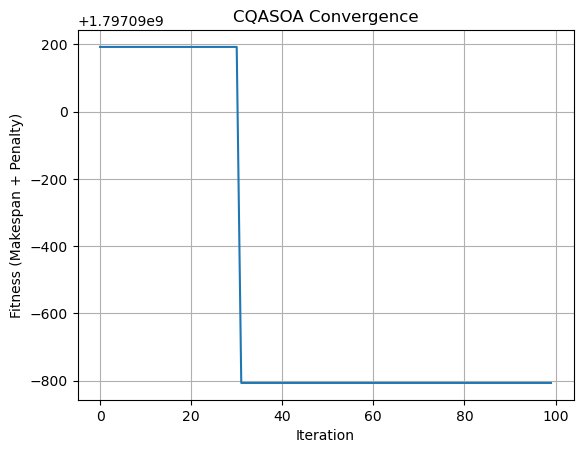


Best Solution:
1. Phân bổ tàu-bến (x):
[[1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]]

2. Phân bổ cần cẩu (q):
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 1]]

3. Phân bổ xe (y):
[[0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [1 1 0 ... 0 0 0]]

Chi tiết thời gian:
Tàu 0: Bến 0, Đến 2025-03-31 03:00:00.223026h, Bắt đầu 2025-03-31 03:00:00.223026h, Chờ 0.0h, Thời điểm kết thúc dự kiến: 2025-03-31 03:00:21.778582h
Tàu 1:

In [75]:
V = len(V_name)   # Số tàu
B = 2   # Số bến
C = 23  # Số cần cẩu
Y = 45  # Số xe
M = 99999  # Penalty
TW0 = 24  # Thời gian chờ tối đa (h)
T = 24
D = np.array(np.array(Dij))
# Thời gian đến và đi (giả lập)
TA = np.array(TAi_float)
PT = np.array(np.array(TF_float) - np.array(TAi_float))
DMN = 14

# --- Các hàm ràng buộc và tiện ích dùng chung ---
def enforce_crane_constraints(q):
    # Đảm bảo mỗi tàu có số cần cẩu nằm trong [VCmi[i], VCMi[i]]
    for i in range(V):
        num_assigned = np.sum(q[i])
        # Thêm cần cẩu ít được sử dụng nhất
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            # Ưu tiên cần cẩu ít được gán cho các tàu khác
            usage = np.sum(q, axis=0)
            sorted_idx = available[np.argsort(usage[available])]
            to_add = min(VCmi[i] - num_assigned, len(sorted_idx))
            if to_add > 0:
                selected = sorted_idx[:to_add]
                q[i, selected] = 1
        # Loại cần cẩu được sử dụng nhiều nhất
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            usage = np.sum(q, axis=0)
            sorted_idx = assigned[np.argsort(-usage[assigned])]
            to_remove = min(num_assigned - VCMi[i], len(sorted_idx))
            if to_remove > 0:
                selected = sorted_idx[:to_remove]
                q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V_, C_ = q2D.shape
    q3D = np.zeros((V_, C_, T), dtype=int)
    for i in range(V_):
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        if num_cranes == 0:
            continue
        total_time = int(np.ceil(VE[i] * CF0))
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0
        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time
    return q3D

def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    C_, T_ = CK.shape
    V_, B_ = D.shape
    for t in range(T_):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False
    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)
    TH = D / v_h
    TL = D / v_l
    for n in range(C_):
        for t in range(T_):
            i, j = A[n, t]
            ck = CK[n, t]
            if ck == 0:
                continue
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator
            if CE_n > CE0:
                return False
    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V_, B_ = x.shape
    for i in range(V_):
        for j in range(B_):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True

def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False

def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)


def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

# ==================== HÀM HIỂN THỊ KẾT QUẢ CHI TIẾT ====================
def show_solution_detail(best_solution):
    print("\nBest Solution:")
    print("1. Phân bổ tàu-bến (x):")
    print(best_solution['x'])
    print("\n2. Phân bổ cần cẩu (q):")
    print(best_solution['q'])
    print("\n3. Phân bổ xe (y):")
    print(best_solution['y'])
    berth_schedule = {j: 0 for j in range(B)}
    print("\nChi tiết thời gian:")
    for i in np.argsort(TA):
        berth = np.argmax(best_solution['x'][i])
        start = max(TA[i], berth_schedule[berth])
        wait = start - TA[i]
        def schedule_cranes(num_containers, num_cranes, cf0=CF0):
            if num_cranes == 0:
                return float('inf')
            return num_containers * cf0 / num_cranes
        num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
        handling_time = schedule_cranes(VEi[i], num_cranes)
        end = TA[i] + handling_time
        print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
        berth_schedule[berth] = start + PT[i]
    makespan = (max(berth_schedule.values()) - min(TA)) / 3600  # Đơn vị: giờ
    print(f"Makespan thực tế: {makespan:.2f} giờ")


def fitness(sol):
    berth_schedule = {j: 0 for j in range(B)}
    completion_times = []
    penalty = 0
    tide_intervals = parse_tide_intervals(Tt)
    w_carbon = 0.01
    # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
    for i in range(V):
        if np.sum(sol['x'][i]) != 1:
            penalty += 1000 * abs(np.sum(sol['x'][i]) - 1)
    # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
    for n in range(C):
        if np.sum(sol['q'][:, n]) > 1:
            penalty += 1000 * (np.sum(sol['q'][:, n]) - 1)
    # Ràng buộc 3: Số cần cẩu cho mỗi tàu nằm trong [VCmi, VCMi]
    for i in range(V):
        total_cranes = np.sum(sol['q'][i])
        if total_cranes < VCmi[i] or total_cranes > VCMi[i]:
            penalty += 1000 * abs(total_cranes - VCmi[i])
    # Ràng buộc 4: Số xe tải cho mỗi tàu (giả sử min 1, max 10)
    for i in range(V):
        total_trucks = np.sum(sol['y'][i])
        if total_trucks < 1:
            penalty += 10000
        if total_trucks > 10:
            penalty += 1000 * (total_trucks - 10)
    if np.sum(sol['y']) > Y:
        penalty += 10000 * (np.sum(sol['y']) - Y)
    # Ràng buộc 5: Chiều dài tàu không vượt chiều dài bến
    for i in range(V):
        berth = np.argmax(sol['x'][i])
        if VLi[i] > BLj[berth]:
            penalty += 10000
    # Ràng buộc 6: Sức chứa bến
    for i in range(V):
        berth = np.argmax(sol['x'][i])
        if VDi[i] > BDj[berth]:
            penalty += 10000
    # Ràng buộc 7: Thời gian chờ không vượt quá TW0
    for i in np.argsort(TA):
        berth = np.argmax(sol['x'][i])
        assigned_cranes = np.sum(sol['q'][i])
        assigned_trucks = np.sum(sol['y'][i])
        if assigned_cranes == 0 or assigned_trucks == 0:
            penalty += 10000
            continue
        arrival_dt = float_to_datetime(TA[i])
        if VDi[i] > DMN:
            if not is_high_tide(arrival_dt, tide_intervals):
                arrival_dt = next_high_tide_time(arrival_dt, tide_intervals)
            TA_adjusted = convert_time_to_float(arrival_dt)
        else:
            TA_adjusted = TA[i]
        start_time = max(float(TA_adjusted), float(berth_schedule[berth]))
        waiting_time = start_time - TA[i]
        if waiting_time > TWi[i]:
            penalty += 1000 * (waiting_time - TWi[i])
        processing_time = float((VEi[i] * CF0) / assigned_cranes)
        transport_delay = D[i, berth] / (assigned_trucks + 1e-5)
        completion = float(start_time + processing_time + transport_delay)
        completion_times.append(completion)
        berth_schedule[berth] = completion
    # Ràng buộc 8: Cần cẩu không nhảy qua nhau
    q3D = schedule_cranes(sol['q'], VEi, CF0, T)
    if not crane_non_crossing_constraint(q3D):
        penalty += 10000
    # Ràng buộc 9: Chiều dài tàu không vượt chiều dài bến (kiểm tra lại)
    if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
        penalty += 10000
    # Ràng buộc 10: Truck constraint
    CK, A = build_CK_A_from_sol(sol, V, C, T, B)
    mu_vh, sigma_vh = 25, 4
    mu_vl, sigma_vl = 18, 3
    if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
        penalty += 10000
    # Carbon emission
    carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
    makespan = max(completion_times) if completion_times else M
    return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty


# ==================== CLASS CQASOA (sẽ hoàn thiện ở các bước tiếp theo) ====================
class CQASOA:
    def __init__(self, n_seagulls=30, max_iter=100, mode='CQASOA', **kwargs):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        self.mode = mode
        self.kwargs = kwargs
        self.pm = kwargs.get('pm', 0.1)  # Xác suất NOT gate
        self.chaos_seed = kwargs.get('chaos_seed', None)

    def initialize(self):
        # Khởi tạo phi lượng tử và chuỗi hỗn loạn cho từng cá thể
        self.population_phi = []
        self.chaos_xs = []
        self.chaos_ys = []
        chaos_len = self.n_seagulls * (V * (B + C + Y))
        if self.chaos_seed is not None:
            np.random.seed(self.chaos_seed)
        x0, y0 = np.random.rand(), np.random.rand()
        xs, ys = self.cat_map_2d(x0, y0, chaos_len)
        idx = 0
        for _ in range(self.n_seagulls):
            phi = {
                'x': np.random.uniform(0, 2*np.pi, (V, B)),
                'q': np.random.uniform(0, 2*np.pi, (V, C)),
                'y': np.random.uniform(0, 2*np.pi, (V, Y))
            }
            self.population_phi.append(phi)
            # Lưu chuỗi hỗn loạn riêng cho từng cá thể
            self.chaos_xs.append(xs[idx:idx+B+C+Y])
            self.chaos_ys.append(ys[idx:idx+B+C+Y])
            idx += (B+C+Y)

    def cat_map_2d(self, x0, y0, n):
        xs, ys = [x0], [y0]
        for _ in range(n-1):
            x_new = (xs[-1] + ys[-1]) % 1
            y_new = (xs[-1] + 2*ys[-1]) % 1
            xs.append(x_new)
            ys.append(y_new)
        return np.array(xs), np.array(ys)

    def phi_to_solution(self, phi):
        x_bin = (np.cos(phi['x']) > 0).astype(int)
        for i in range(x_bin.shape[0]):
            if np.sum(x_bin[i]) != 1:
                idx = np.argmax(phi['x'][i])
                x_bin[i] = 0
                x_bin[i, idx] = 1
        q_bin = (np.cos(phi['q']) > 0).astype(int)
        q_bin = enforce_crane_constraints(q_bin)
        y_bin = (np.cos(phi['y']) > 0).astype(int)
        # Đảm bảo số xe hợp lệ (giống QSOA)
        y_bin = self.enforce_truck_constraints_optimized(y_bin, M)
        return {'x': x_bin, 'q': q_bin, 'y': y_bin}

    def enforce_truck_constraints_optimized(self, y, num_trucks, min_truck_per_vessel=1, max_truck_per_vessel=10):
        V_, M_ = y.shape
        # Đảm bảo mỗi tàu có số xe hợp lệ
        for i in range(V_):
            current = np.sum(y[i])
            if current < min_truck_per_vessel:
                available = np.where(np.sum(y, axis=0) == 0)[0]
                usage = np.sum(y, axis=0)
                sorted_idx = available[np.argsort(usage[available])]
                to_add = min(min_truck_per_vessel - current, len(sorted_idx))
                if to_add > 0:
                    selected = sorted_idx[:to_add]
                    y[i, selected] = 1
            if np.sum(y[i]) > max_truck_per_vessel:
                assigned = np.where(y[i] == 1)[0]
                usage = np.sum(y, axis=0)
                sorted_idx = assigned[np.argsort(-usage[assigned])]
                to_remove = min(np.sum(y[i]) - max_truck_per_vessel, len(sorted_idx))
                if to_remove > 0:
                    selected = sorted_idx[:to_remove]
                    y[i, selected] = 0
        # Đảm bảo tổng số xe không vượt quá num_trucks
        sort_idx = np.arange(V_)
        max_iter = 1000
        iter_cnt = 0
        while np.sum(y) > num_trucks and iter_cnt < max_iter:
            changed = False
            for i in reversed(sort_idx):
                assigned = np.where(y[i] == 1)[0]
                if len(assigned) > min_truck_per_vessel:
                    usage = np.sum(y, axis=0)
                    sorted_idx = assigned[np.argsort(-usage[assigned])]
                    y[i, sorted_idx[0]] = 0
                    changed = True
                    break
            if not changed:
                break
            iter_cnt += 1
        iter_cnt = 0
        while np.sum(y) < num_trucks and iter_cnt < max_iter:
            changed = False
            for i in sort_idx:
                assigned = np.where(y[i] == 0)[0]
                if np.sum(y[i]) < max_truck_per_vessel and len(assigned) > 0:
                    usage = np.sum(y, axis=0)
                    sorted_idx = assigned[np.argsort(usage[assigned])]
                    y[i, sorted_idx[0]] = 1
                    changed = True
                    break
            if not changed:
                break
            iter_cnt += 1
        return y

    def chaos_update(self, phi, chaos_x, chaos_y):
        # Xáo trộn các pha lượng tử bằng chuỗi hỗn loạn (cat map)
        phi_new = deepcopy(phi)
        # Xáo trộn từng dòng của x, q, y bằng chaos_x, chaos_y
        for key, chaos in zip(['x', 'q', 'y'], [chaos_x[:B], chaos_x[B:B+C], chaos_x[B+C:]]):
            arr = phi_new[key]
            for i in range(arr.shape[0]):
                idx = np.argsort(chaos)[:arr.shape[1]]
                arr[i] = arr[i][idx]
        return phi_new

    def quantum_update(self, phi):
        # Quantum Revolving Gate + NOT gate
        delta_phi_x = np.random.uniform(-np.pi/16, np.pi/16, phi['x'].shape)
        delta_phi_q = np.random.uniform(-np.pi/16, np.pi/16, phi['q'].shape)
        delta_phi_y = np.random.uniform(-np.pi/16, np.pi/16, phi['y'].shape)
        phi_new = {
            'x': phi['x'] + delta_phi_x,
            'q': phi['q'] + delta_phi_q,
            'y': phi['y'] + delta_phi_y
        }
        if np.random.rand() < self.pm:
            phi_new['x'] = np.pi/2 - phi_new['x']
            phi_new['q'] = np.pi/2 - phi_new['q']
            phi_new['y'] = np.pi/2 - phi_new['y']
        return phi_new

    def adaptive_update(self, t):
        fc = 2
        return fc * (np.cos(np.pi * (t / self.max_iter)) + 1) / 2

    


    def optimize(self):
        self.initialize()
        fitness_history = []
        best_phi = min(self.population_phi, key=lambda phi: fitness(self.phi_to_solution(phi)))
        best_sol = self.phi_to_solution(best_phi)
        for iter in range(self.max_iter):
            A = self.adaptive_update(iter)
            new_population_phi = []
            new_chaos_xs = []
            new_chaos_ys = []
            # Elitism: giữ lại best
            best_phi = min(self.population_phi, key=lambda phi: fitness(self.phi_to_solution(phi)))
            best_idx = next(i for i, phi in enumerate(self.population_phi) if phi is best_phi)
            new_population_phi.append(best_phi)
            new_chaos_xs.append(self.chaos_xs[best_idx])
            new_chaos_ys.append(self.chaos_ys[best_idx])
            for i, phi in enumerate(self.population_phi):
                if i == best_idx:
                    continue
                # 1. Chaos update
                phi_chaos = self.chaos_update(phi, self.chaos_xs[i], self.chaos_ys[i])
                # 2. Quantum update
                phi_quantum = self.quantum_update(phi_chaos)
                # 3. Adaptive: điều chỉnh mutation/mask (có thể dùng cho NOT gate hoặc chaos strength)
                # (Ở đây đã điều chỉnh mutation/mask qua adaptive_update, có thể mở rộng thêm)
                new_population_phi.append(phi_quantum)
                new_chaos_xs.append(self.chaos_xs[i])
                new_chaos_ys.append(self.chaos_ys[i])
            self.population_phi = new_population_phi
            self.chaos_xs = new_chaos_xs
            self.chaos_ys = new_chaos_ys
            best_phi = min(self.population_phi, key=lambda phi: fitness(self.phi_to_solution(phi)))
            best_sol = self.phi_to_solution(best_phi)
            fitness_history.append(fitness(best_sol))
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        plt.plot(fitness_history)
        plt.title("CQASOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol


cqasoa = CQASOA(n_seagulls=30, max_iter=100)
best_solution = cqasoa.optimize()
show_solution_detail(best_solution)